In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
from sunpy.physics.differential_rotation import solar_rotate_coordinate
import sunkit_image
import sunkit_image.coalignment as coalignment
import sunkit_image.enhance as enhance
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import h5py

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   
from glob import glob
import cv2
import flow_vis
import sys

from collections import OrderedDict

import cv2
import numpy as np
import torch
from argparse import Namespace

sys.path.append("/home/yjzhu/scripts/RAFT/core/")
from raft import RAFT
from utils import flow_viz

In [3]:
eui_files = sorted(glob("../../src/EUI/HRI/euv174/20221024/solo_L2_eui-hri*.fits"))

In [4]:
eui_map_all = sunpy.map.Map(eui_files[171:182], sequence=True, memmap=True)
eui_centers = [m.center for m in eui_map_all]

In [5]:
with h5py.File("../../src/EUI/HRI/euv174/20221024/coalign_shifts_step.h5","r") as f:
    eui_map_seq_coalign_shifts_x = f["x"][()]
    eui_map_seq_coalign_shifts_y = f["y"][()]
eui_map_seq_coalign_shifts = {"x":eui_map_seq_coalign_shifts_x[171:182]*u.arcsec,"y":eui_map_seq_coalign_shifts_y[171:182]*u.arcsec}

In [6]:
eui_map_seq_coalign = coalignment.mapsequence_coalign_by_match_template(eui_map_all,shift=eui_map_seq_coalign_shifts)

In [7]:
Txshift_hri, Tyshift_hri = (1.66986 + 2.49223)*u.arcsec,(7.60204 - 2.76366 )*u.arcsec

In [8]:
eis_195_velmap_derot_repro_shifted_hrifov = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")
eis_hhflare_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_derot_repro_hrifov.fits")

In [9]:
eui_map_181 = eui_map_seq_coalign[-1].shift_reference_coord(Txshift_hri,Tyshift_hri)
eui_map_181.meta["rsun_ref"] = 696000000.0
eui_wcs_all = eui_map_181.wcs

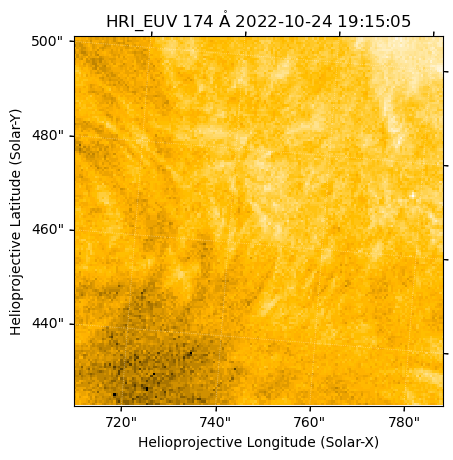

In [10]:
eui_map_181_east_1 = eui_map_181.submap([500,600]*u.pix,
                                        top_right=[659,759]*u.pix)
eui_map_181_east_1.plot()

In [11]:
eui_map_181_east_1_fake = eui_map_181.submap([490,590]*u.pix,
                                        top_right=[649,749]*u.pix)
eui_map_181_east_1_fake = sunpy.map.Map(eui_map_181_east_1_fake.data,eui_map_181_east_1.meta)

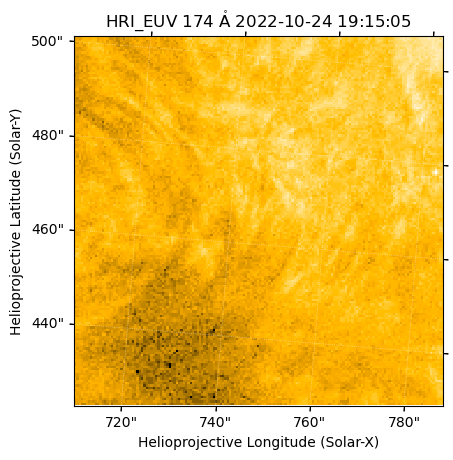

In [12]:
eui_map_181_east_1_fake.plot()

In [13]:
def frame_preprocess(frame, device):
    frame = torch.from_numpy(frame).permute(2, 0, 1).float()
    frame = frame.unsqueeze(0)
    frame = frame.to(device)
    return frame

In [14]:
def vizualize_flow(img, flo, save, counter):
    # permute the channels and change device is necessary
    img = img[0].permute(1, 2, 0).cpu().numpy()
    flo = flo[0].permute(1, 2, 0).cpu().numpy()

    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    flo = cv2.cvtColor(flo, cv2.COLOR_RGB2BGR)

    # concatenate, save and show images
    img_flo = np.concatenate([img, flo], axis=0)
    #if save:
    #    cv2.imwrite(f"demo_frames/frame_{str(counter)}.jpg", img_flo)
    plt.imshow(img_flo / 255.0)
    plt.show()
    #k = cv2.waitKey(25) & 0xFF
    #if k == 27:
    #    return False
    #return True

    return False

In [15]:
def get_cpu_model(model):
    new_model = OrderedDict()
    # get all layer's names from model
    for name in model:
        # create new name and update new model
        new_name = name[7:]
        new_model[new_name] = model[name]
    return new_model

In [16]:
def calc_dense_optical_flow_raft(mapseq,args,bottom_left=None, top_right=None):
    # get the RAFT model
    model = RAFT(args)
    # load pretrained weights
    
    save = args.save
    if save:
        if not os.path.exists("demo_frames"):
            os.mkdir("demo_frames")

    if torch.cuda.is_available():
        pretrained_weights = torch.load(args.model)
        device = "cuda"
        # parallel between available GPUs
        model = torch.nn.DataParallel(model)
        # load the pretrained weights into model
        model.load_state_dict(pretrained_weights)
        model.to(device)
    else:
        pretrained_weights = torch.load(args.model,map_location=torch.device('cpu'))
        device = "cpu"
        # change key names for CPU runtime
        pretrained_weights = get_cpu_model(pretrained_weights)
        # load the pretrained weights into model
        model.load_state_dict(pretrained_weights)

    # change model's mode to evaluation
    model.eval()

    for ii in range(len(mapseq)-1):
        if bottom_left is None:
            map_prev = mapseq[ii]
            map_next = mapseq[ii+1]
        else:
            map_prev = mapseq[ii].submap(bottom_left, top_right=top_right)
            map_next = mapseq[ii+1].submap(bottom_left, top_right=top_right)

        prev = cv2.normalize(map_prev.data, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        next = cv2.normalize(map_next.data, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

        frame_1 = frame_preprocess(np.dstack((prev,prev,prev)), device)
        frame_2 = frame_preprocess(np.dstack((next,next,next)), device)

        flow_low, flow_up = model(frame_1, frame_2, iters=args.iters, test_mode=True)

        if ii == 0:
            flow_low_all = flow_low
            flow_up_all = flow_up
        else:
            flow_low_all = torch.cat((flow_low_all, flow_low), 0)
            flow_up_all = torch.cat((flow_up_all, flow_up), 0)

    return flow_low_all, flow_up_all


    


In [17]:
args_dict = {"model":'/home/yjzhu/scripts/RAFT/models/raft-sintel.pth', "iters":12, "save":False, "small":False, "mixed_precision":False}
args = Namespace(**args_dict)
optical_flow_east_1_flow_low_fake, optical_flow_east_1_flow_up_fake = calc_dense_optical_flow_raft(sunpy.map.Map([eui_map_181_east_1_fake,eui_map_181_east_1_fake]),args)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706712279749/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [18]:
optical_flow_east_1_flow_up_fake_0_np = optical_flow_east_1_flow_up_fake[0].permute(1, 2, 0).detach().numpy()
optical_flow_east_1_flow_up_vis_fake = flow_viz.flow_to_image(optical_flow_east_1_flow_up_fake_0_np)

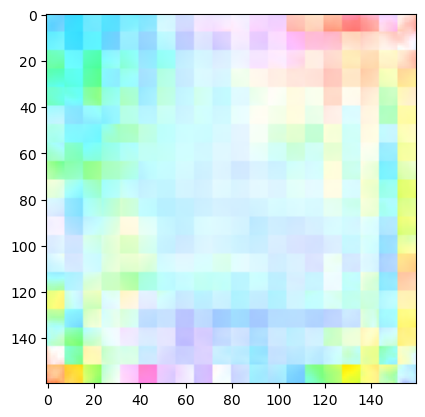

In [19]:
plt.imshow(optical_flow_east_1_flow_up_vis_fake)

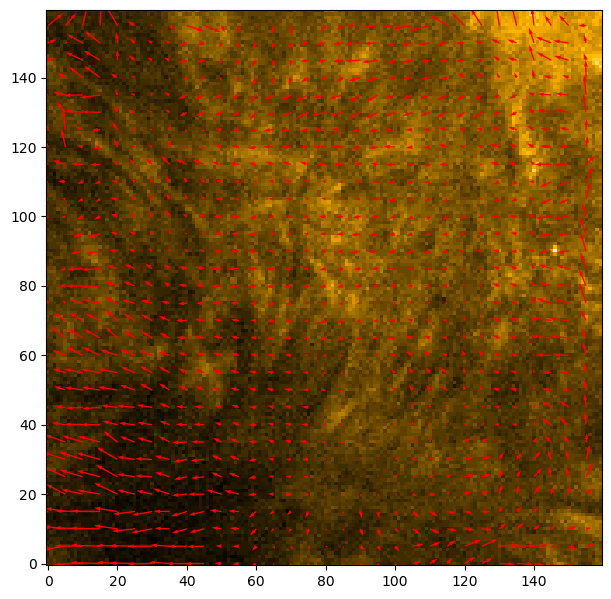

In [20]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

ax.imshow(eui_map_181_east_1.data, cmap='solar orbiterhri_euv174',origin="lower")
ax.quiver(np.arange(0,optical_flow_east_1_flow_up_fake_0_np.shape[1],5),np.arange(0,optical_flow_east_1_flow_up_fake_0_np.shape[0],5),
          optical_flow_east_1_flow_up_fake_0_np[::5,::5,0],optical_flow_east_1_flow_up_fake_0_np[::5,::5,1],color='r')

In [21]:
optical_flow_east_1_flow_low, optical_flow_east_1_flow_up = calc_dense_optical_flow_raft(eui_map_seq_coalign[:2],args,[500,600]*u.pix,top_right=[659,759]*u.pix)

In [22]:
optical_flow_east_1_flow_up_0_np = optical_flow_east_1_flow_up[0].permute(1, 2, 0).detach().numpy()
optical_flow_east_1_flow_up_vis = flow_viz.flow_to_image(optical_flow_east_1_flow_up_0_np)

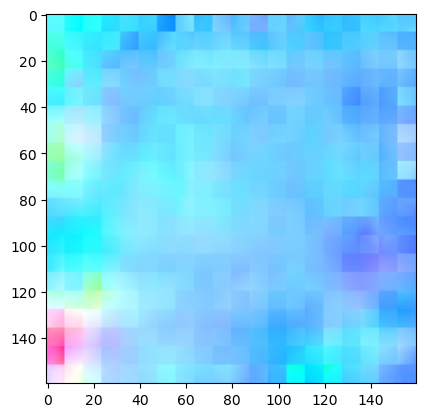

In [23]:
plt.imshow(optical_flow_east_1_flow_up_vis)

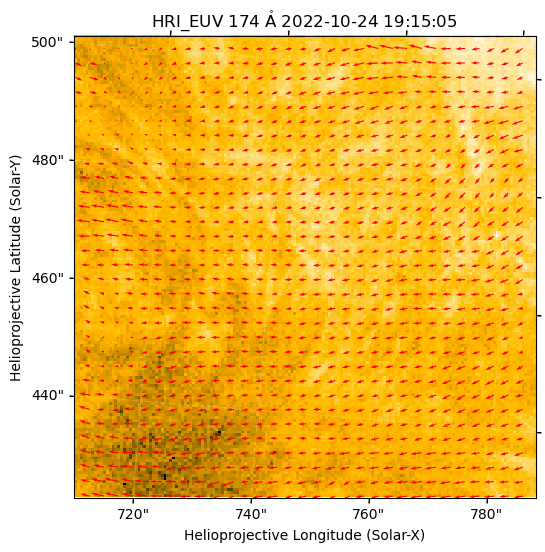

In [24]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111,projection=eui_map_181_east_1.wcs)

eui_map_181_east_1.plot(axes=ax)
ax.quiver(np.arange(0,optical_flow_east_1_flow_up_0_np.shape[1],5),np.arange(0,optical_flow_east_1_flow_up_0_np.shape[0],5),
            optical_flow_east_1_flow_up_0_np[::5,::5,0],optical_flow_east_1_flow_up_0_np[::5,::5,1],color='r')

In [107]:
optical_flow_east_1_0_mag, optical_flow_east_1_0_ang = cv2.cartToPolar(optical_flow_east_1[0,:,:,0], optical_flow_east_1[0,:,:,1])

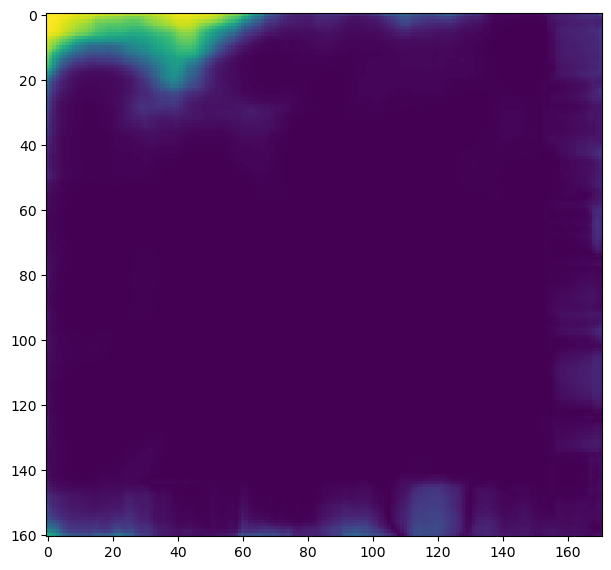

In [108]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

ax.imshow(optical_flow_east_1_0_mag, cmap='viridis')

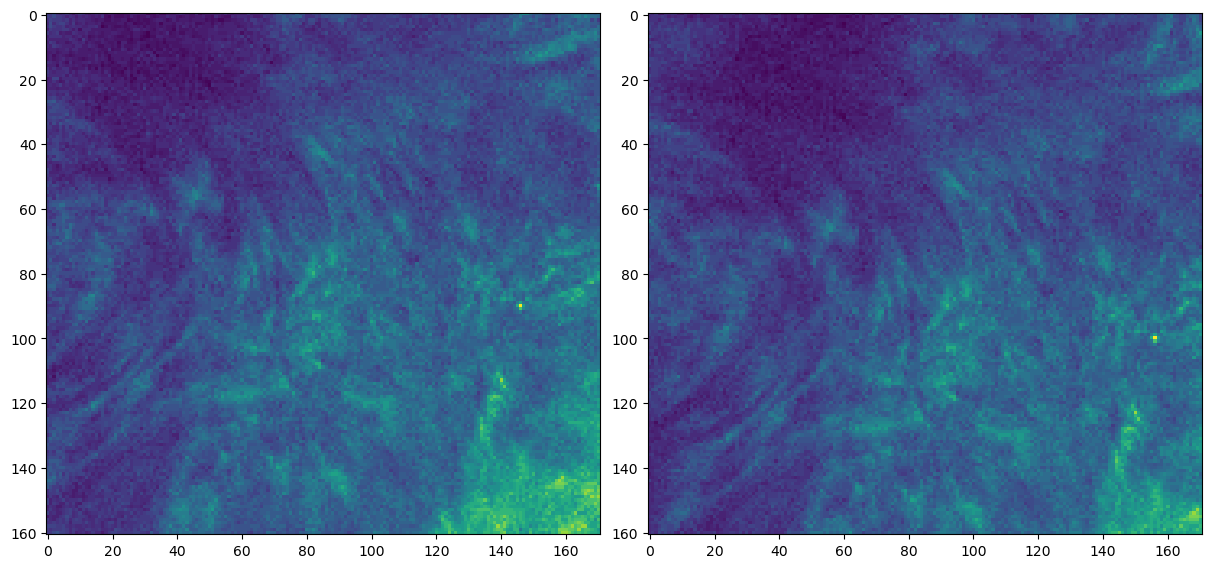

In [109]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6),layout='constrained')

ax1.imshow(eui_map_181_east_1.data)

ax2.imshow(eui_map_181_east_1_fake.data)

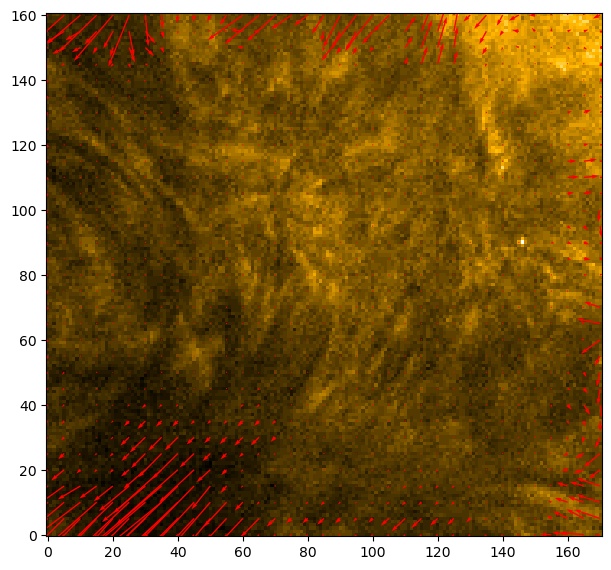

In [110]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

ax.imshow(eui_map_181_east_1.data, cmap='solar orbiterhri_euv174',origin="lower")
ax.quiver(np.arange(0,optical_flow_east_1.shape[2],5),np.arange(0,optical_flow_east_1.shape[1],5),
          optical_flow_east_1[0,::5,::5,0],optical_flow_east_1[0,::5,::5,1],color='r')

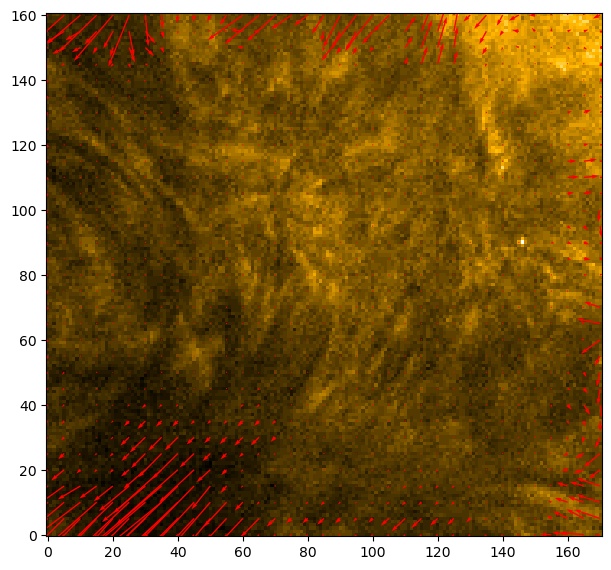

In [111]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

ax.imshow(eui_map_181_east_1.data, cmap='solar orbiterhri_euv174',origin='lower')
ax.quiver(np.arange(0,optical_flow_east_1.shape[2],5),np.arange(0,optical_flow_east_1.shape[1],5),
          optical_flow_east_1[0,::5,::5,0],optical_flow_east_1[0,::5,::5,1],color='r')

In [123]:
optical_flow_east_1_test = calc_dense_optical_flow_farneback(eui_map_seq_coalign, bottom_left=[500,600]*u.pix,top_right=[670,760]*u.pix,)
optical_flow_east_1_test_2 = calc_dense_optical_flow_farneback(eui_map_seq_coalign, bottom_left=[500,600]*u.pix,top_right=[670,760]*u.pix,
                                                             params=[0.5, 5, 20, 10, 5, 1.1, 0])

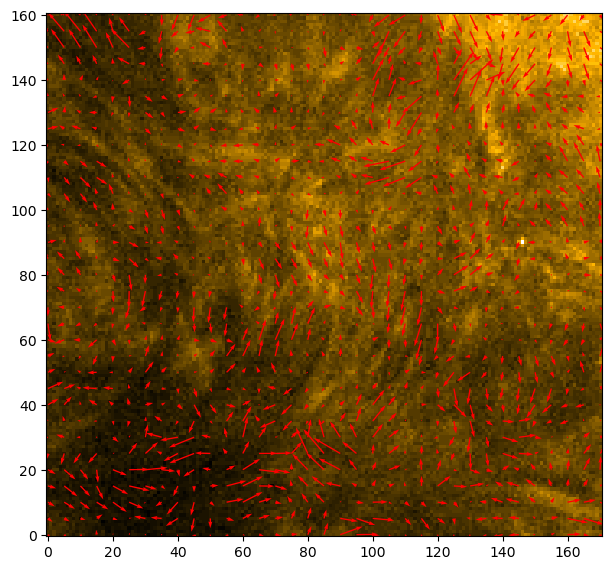

In [113]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

ax.imshow(eui_map_181_east_1.data, cmap='solar orbiterhri_euv174',origin='lower')
ax.quiver(np.arange(0,optical_flow_east_1_test.shape[2],5),np.arange(0,optical_flow_east_1_test.shape[1],5),
          optical_flow_east_1_test[0,::5,::5,0],optical_flow_east_1_test[0,::5,::5,1],color='r')

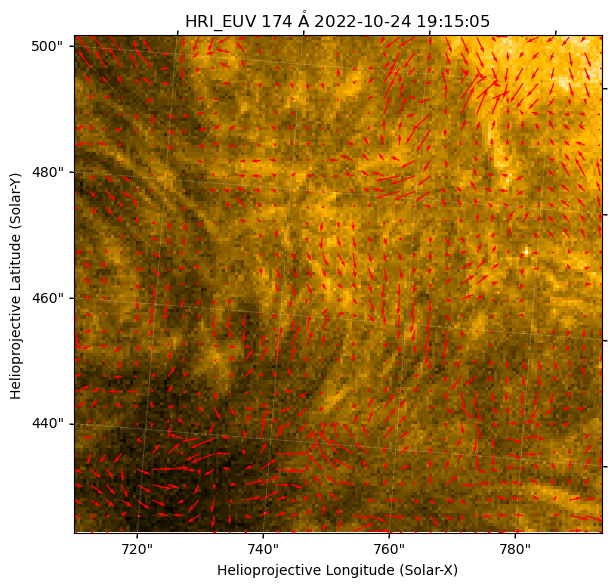

In [114]:
fig = plt.figure(figsize=(6,6),layout='constrained')

ax = fig.add_subplot(111,projection=eui_map_181_east_1,)

eui_map_181_east_1.plot(axes=ax,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))

ax.quiver(np.arange(0,optical_flow_east_1_test.shape[2],5),np.arange(0,optical_flow_east_1_test.shape[1],5),
            optical_flow_east_1_test[0,::5,::5,0],optical_flow_east_1_test[0,::5,::5,1],color='r')

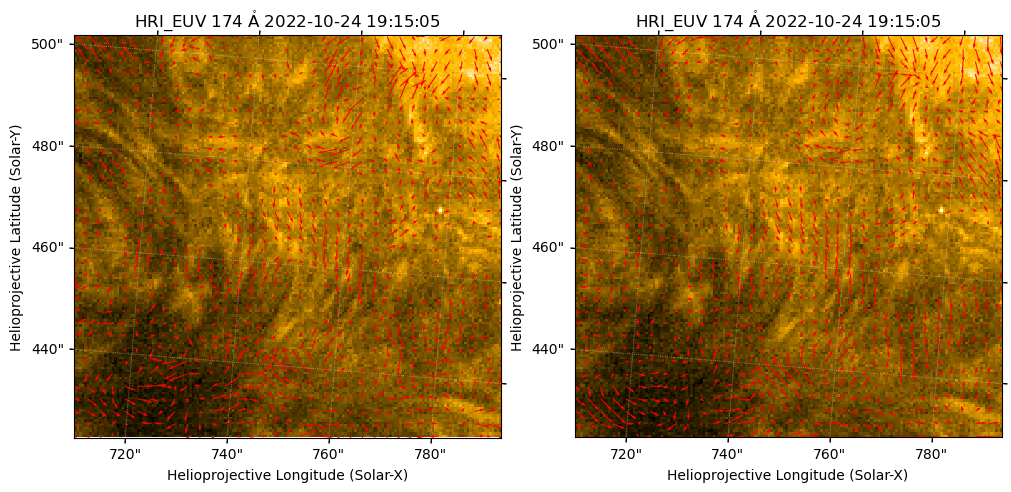

In [124]:
fig = plt.figure(figsize=(10,5),layout='constrained')

ax1 = fig.add_subplot(121,projection=eui_map_181_east_1,)
ax2 = fig.add_subplot(122,projection=eui_map_181_east_1,)

eui_map_181_east_1.plot(axes=ax1,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))
eui_map_181_east_1.plot(axes=ax2,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))

ax1.quiver(np.arange(0,optical_flow_east_1_test.shape[2],5),np.arange(0,optical_flow_east_1_test.shape[1],5),
            optical_flow_east_1_test[0,::5,::5,0],optical_flow_east_1_test[0,::5,::5,1],color='r')

ax2.quiver(np.arange(0,optical_flow_east_1_test_2.shape[2],5),np.arange(0,optical_flow_east_1_test_2.shape[1],5),
            optical_flow_east_1_test_2[0,::5,::5,0],optical_flow_east_1_test_2[0,::5,::5,1],color='r')

In [115]:
def mag_ang_to_rgb(mag, ang):
    hsv = np.zeros((mag.shape[0],mag.shape[1],3),dtype=np.uint8)
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,1] = 128
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [116]:
optical_flow_east_1_test_hsv = mag_ang_to_rgb(optical_flow_east_1_test[0,:,:,2],optical_flow_east_1_test[0,:,:,3])

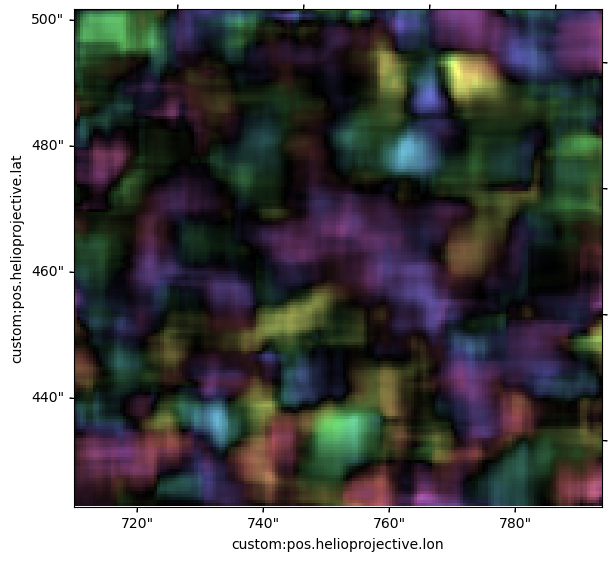

In [117]:
fig = plt.figure(figsize=(6,6),layout='constrained')

ax = fig.add_subplot(111,projection=eui_map_181_east_1,)

ax.imshow(optical_flow_east_1_test_hsv,origin="lower")

In [118]:
optical_flow_east_1_test_hsv_flow_vis = flow_vis.flow_to_color(optical_flow_east_1_test[0,:,:,:2],)

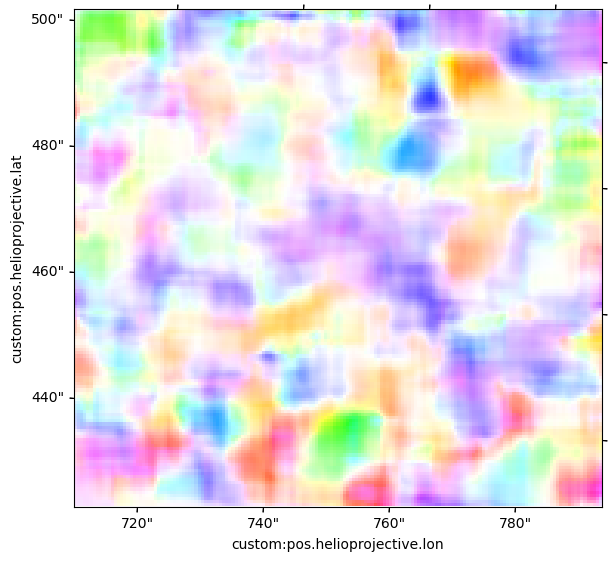

In [119]:
fig = plt.figure(figsize=(6,6),layout='constrained')

ax = fig.add_subplot(111,projection=eui_map_181_east_1,)

ax.imshow(optical_flow_east_1_test_hsv_flow_vis,origin="lower")

In [120]:
def draw_hsv_color_wheel(ax,vmin=0,vmax=1.5,samples=1024,clip_circle=True):
    xx, yy = np.meshgrid(
    np.linspace(-vmax, vmax, samples), np.linspace(-vmax, vmax, samples))

    rr = np.sqrt(xx**2 + yy**2) 

    color_wheel_rgb = flow_vis.flow_to_color(np.dstack((xx,yy)))

    if clip_circle == True:
        color_wheel_rgb[rr > vmax] = 255
        color_wheel_a = np.where(rr > vmax, 255, 255)
    else:
        color_wheel_a = np.ones(rr.shape)*255

    color_wheel_rgba = np.dstack((color_wheel_rgb,color_wheel_a))

    ax.imshow(color_wheel_rgba,extent=(-vmax,vmax,-vmax,vmax),origin="lower")

    ax.set_axis_off()

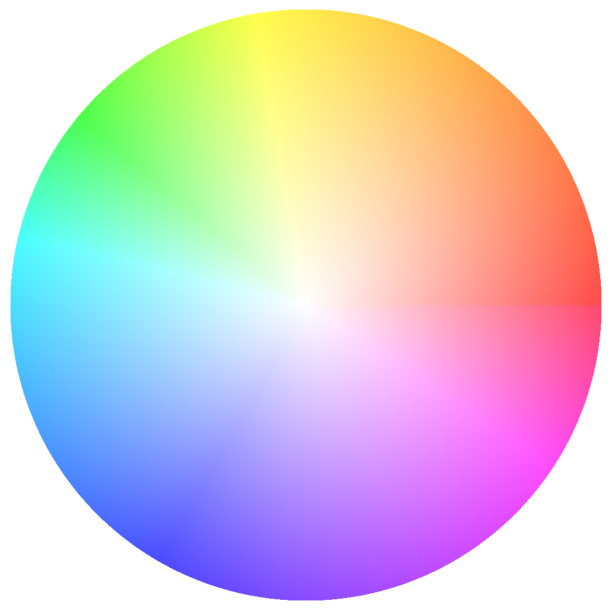

In [121]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

color_wheel_rgba = draw_hsv_color_wheel(ax,clip_circle=True)

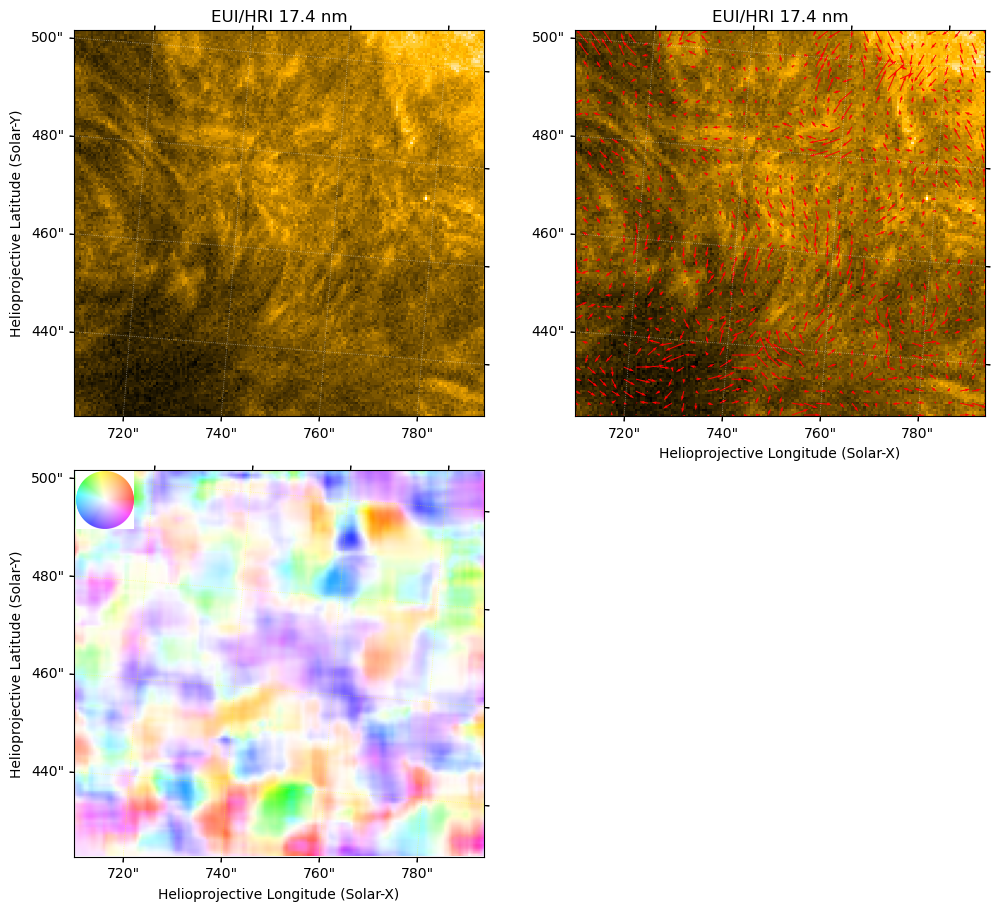

In [122]:
fig = plt.figure(figsize=(10,9),layout='constrained')

ax1 = fig.add_subplot(221,projection=eui_map_181_east_1,)

eui_map_181_east_1.plot(axes=ax1,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)),
                        title="EUI/HRI 17.4 nm")

ax2 = fig.add_subplot(222,projection=eui_map_181_east_1,)
eui_map_181_east_1.plot(axes=ax2,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)),
                        title="EUI/HRI 17.4 nm")

ax2.quiver(np.arange(0,optical_flow_east_1_test.shape[2],5),np.arange(0,optical_flow_east_1_test.shape[1],5),
            optical_flow_east_1_test[0,::5,::5,0],optical_flow_east_1_test[0,::5,::5,1],color='r')

ax2.set_ylabel(' ')

ax3 = fig.add_subplot(223,projection=eui_map_181_east_1,)

ax3.imshow(optical_flow_east_1_test_hsv_flow_vis,origin="lower")

ax3_wheel_ax = inset_axes(ax3,width="100%",height="100%",loc="upper left",
                bbox_to_anchor=[0,0.847,0.15,0.15],
                 bbox_transform=ax3.transAxes,
                 borderpad=0)

draw_hsv_color_wheel(ax3_wheel_ax,clip_circle=True)

ax3.grid("on",lw=0.5,ls=":",color="yellow",alpha=0.5)

ax3.set_ylabel(ax1.get_ylabel())
ax3.set_xlabel(ax1.get_xlabel())

ax1.set_xlabel(' ')

# ax4 = fig.add_subplot(224,projection=eui_map_181_east_1,)

# ax4.imshow((eui_map_seq_coalign[1].data - eui_map_seq_coalign[0].data)/eui_map_se, cmap='binary',origin='lower')